In [22]:
import os
import random
import math
import torch
from torch import nn
from torch.nn import functional as F
import torchtext
import torchdata
from torch.utils import data
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import load
import pretty_midi
import music21
from music21 import *
import soundfile
import pyphen
import IPython
import os
#TODO fix whatever this is
music21.environment.set("musescoreDirectPNGPath", "C:\\Users\\tyler\\OneDrive\\Documents\\Projects\\Python\\SongSmith\\bin\\musescore3.exe") # tell music21 where MuseScore is installed

In [71]:
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model%2 != 0:
            pe[:, 1::2] = torch.cos(position * div_term)[:,0:-1]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """
        
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class Generator(nn.Module):
    def __init__(self, unembedded_input_size, word_vocab_size, syll_vocab_size, embed_size = 10):
        super(Generator, self).__init__()
        self.unembedded_input_size = unembedded_input_size
        size_wo_lyrics = unembedded_input_size - 2
        self.embedded_input_size = size_wo_lyrics + embed_size * 2
        self.embed_size = embed_size

        self.word_embedding = nn.Embedding(word_vocab_size, embed_size)
        self.syll_embedding = nn.Embedding(syll_vocab_size, embed_size)

        self.pos_encoder = PositionalEncoding(self.embedded_input_size, dropout = 0) # for now, no dropout cause no trust

        encoder_layers = nn.TransformerEncoderLayer(
            d_model = self.embedded_input_size, 
            nhead = 2,
            dim_feedforward=4,
            dropout=0,
            batch_first=True
            )

        self.norm = nn.LayerNorm(self.embedded_input_size)
        self.encoder = nn.TransformerEncoder(encoder_layers, num_layers=4, norm=self.norm)

        # need linear layer to match input sizes for cross-attention in decoder
        self.encoder_out = nn.Linear(self.embedded_input_size, 3) 

        decoder_layers = nn.TransformerDecoderLayer(
            d_model = 3, 
            nhead = 1,
            dim_feedforward=4,
            dropout=0,
            batch_first=True
            )
        
        self.decoder = nn.TransformerDecoder(decoder_layers, num_layers=4)

        self.init_weights()

    def forward(self, src):
        batch_size = src.shape[0]
        seq_len = src.shape[1]

        src_emb = self.embed_lyrics(src)
        src_emb = self.pos_encoder(src_emb) 

        memory = self.encoder(src_emb)
        memory = self.encoder_out(memory)

        # generate a melody with same seq_len as src
        tgt = torch.zeros((batch_size, 1, 3)) # start with zero note 
        for i in range(seq_len - 1): # -1 cause we already have 0 note
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.shape[1])
            output = self.decoder(tgt, memory, tgt_mask)
            output = output[:, -1] # extracts the inference because the output is formatted weirdly 
            output = output.view(batch_size, 1, -1) # reshapes output to be batch friendly
            tgt = torch.cat((tgt, output), dim=1)

        # add the lyrics
        words = src[:, :, self.unembedded_input_size - 2].reshape(batch_size, seq_len, 1)
        sylls = src[:, :, self.unembedded_input_size - 1].reshape(batch_size, seq_len, 1)        
        tgt = torch.cat((tgt, words), dim=2)
        tgt = torch.cat((tgt, sylls), dim=2)

        return tgt
    
    # returns X but with the words and syllables embedded and positional encoded
    def embed_lyrics(self, X):
        batch_size = X.shape[0]
        seq_len = X.shape[1]
        assert X.shape[2] == self.unembedded_input_size

        # extract words and syllables from X
        words = X[:, :, self.unembedded_input_size - 2].long()
        sylls = X[:, :, self.unembedded_input_size - 1].long()

        # do embedding
        words_embedded = self.word_embedding(words)
        sylls_embedded = self.syll_embedding(sylls)

        # reshape so you can concate
        words_embedded = words_embedded.view(batch_size, seq_len, self.embed_size)
        sylls_embedded = sylls_embedded.view(batch_size, seq_len, self.embed_size)

        # concat everything and return
        X_embedded = X[:, :, :self.unembedded_input_size - 2] # minus 2 to kill words and syllables
        X_embedded = torch.cat((X_embedded, words_embedded), dim=2)
        X_embedded = torch.cat((X_embedded, sylls_embedded), dim=2)

        return X_embedded

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.word_embedding.weight, -initrange, initrange)
        nn.init.uniform_(self.syll_embedding.weight, -initrange, initrange)
        nn.init.zeros_(self.encoder_out.bias)
        nn.init.uniform_(self.encoder_out.weight, -initrange, initrange)


def discretize(sample):
    authorized_values_pitch = torch.tensor(range(127))
    authorized_values_duration = torch.tensor([0.25,  0.5, 0.75, 1., 1.5, 2., 3., 4., 6., 8., 16., 32.])
    authorized_values_rest = torch.tensor([0., 1., 2., 4., 8., 16., 32.])

    discretized = torch.zeros_like(sample)
    # copy over words and syllables
    discretized[:, 3] = sample[:, 3]
    discretized[:, 4] = sample[:, 4]

    for i in range(len(sample)): # for each note
        # each finds the authorized value that has the least squared distance 

        # fix the pitch
        best_idx = torch.argmin((sample[i][0] - authorized_values_pitch) ** 2)
        discretized[i][0] = authorized_values_pitch[best_idx]

        # fix the duration
        best_idx = torch.argmin((sample[i][1] - authorized_values_duration) ** 2)
        discretized[i][1] = authorized_values_duration[best_idx]
        
        # fix the rest
        best_idx = torch.argmin((sample[i][2] - authorized_values_rest) ** 2)
        discretized[i][2] = authorized_values_rest[best_idx]

    return discretized

def midi_to_note(midi: int, duration: float, syll: str):
    duration = music21.duration.Duration(duration)

    NOTES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    OCTAVES = list(range(11))
    NOTES_IN_OCTAVE = len(NOTES)
    
    octave = midi // NOTES_IN_OCTAVE
    note = NOTES[midi % NOTES_IN_OCTAVE]
    note = music21.note.Note(f"{note}{octave}", duration = duration)
    note.lyric = syll

    return note

def playSong(example):
    syll_vocab = load('./vocabs/syll_vocab.npy')

    pm = pretty_midi.PrettyMIDI()
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=piano_program)
    pm.instruments.append(piano)
    music21_notes = []

    # add notes
    time = 0
    for note in example:
        pitch = note[0].long().item()
        dur = note[1].item()
        rest_dur = note[2].item()
        syll = syll_vocab[note[4].long().item()]

        note = pretty_midi.Note(velocity=100, pitch = pitch, start = time + rest_dur, end = time + dur)
        time = rest_dur + time + dur
        piano.notes.append(note)

        if (rest_dur != 0): music21_notes.append(music21.note.Rest(duration=music21.duration.Duration(rest_dur)))
        
        music21_notes.append(midi_to_note(pitch, dur, syll))


    # synthesize audio
    fs = 44100
    audio_data = pm.fluidsynth(fs)
    #audio_data

    return IPython.display.Audio(audio_data, rate=fs), audio_data, music21_notes

def create_syll(words):
    sylls = []
    new_words = []
    dic = pyphen.Pyphen(lang='nl_NL')

    for word in words:
        temp_syll = dic.inserted(word).split("-")
        temp_words = [word] * len(temp_syll)
        sylls.append(temp_syll)
        new_words.append(temp_words)
    assert len(sylls) == len(new_words), "input syllables size does not match words size"
    yield sylls
    yield new_words

def embed_lyrics(sylls, words):
    word_vocab = load('./vocabs/word_vocab.npy')
    syll_vocab = load('./vocabs/syll_vocab.npy')

    for i in range(len(sylls)):
        try:
            sylls[i] = syll_vocab.where(a == sylls[i])[0][0]
        except:
            sylls[i] = random.randint(0, len(syll_vocab))
        try:
            words[i] = syll_vocab.where(a == words[i])[0][0]
        except:
            words[i] = random.randint(0, len(word_vocab))

    yield sylls
    yield words


def create_song(lyrics):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    input = create_syll(lyrics)
    syl_word = embed_lyrics(next(input), next(input))
    sylls= next(syl_word)
    words = next(syl_word)

    seq_len = len(sylls)
    batch_size = 1

    gen = torch.load("GenModel.pt", map_location=torch.device('cpu'))
    gen = gen.to(device) 

    noise = torch.normal(0, 1, size=(batch_size ,seq_len, 4))
    words = np.array(words).reshape(batch_size, seq_len, 1)
    sylls = np.array(sylls).reshape(batch_size, seq_len, 1)
    src = torch.cat((noise, torch.tensor(words)), dim=2)
    src = torch.cat((src, torch.tensor(sylls)), dim=2)

    tgt = gen(src)
    generated_sample = tgt[0]
    generated_sample = discretize(generated_sample)
    mp3, audio_data, music21_notes = playSong(generated_sample)
    stream = music21.stream.Stream(music21_notes)
    stream.write('xml', fp="test.xml")
    music_xml= os.path.join('.','test.xml')
    s = music21.converter.parse(music_xml)
    s.show('ipython.musicxml.png', fp="./static/img/generate/sheet_music.png")
    soundfile.write('audio2.mp3', audio_data, 44100)


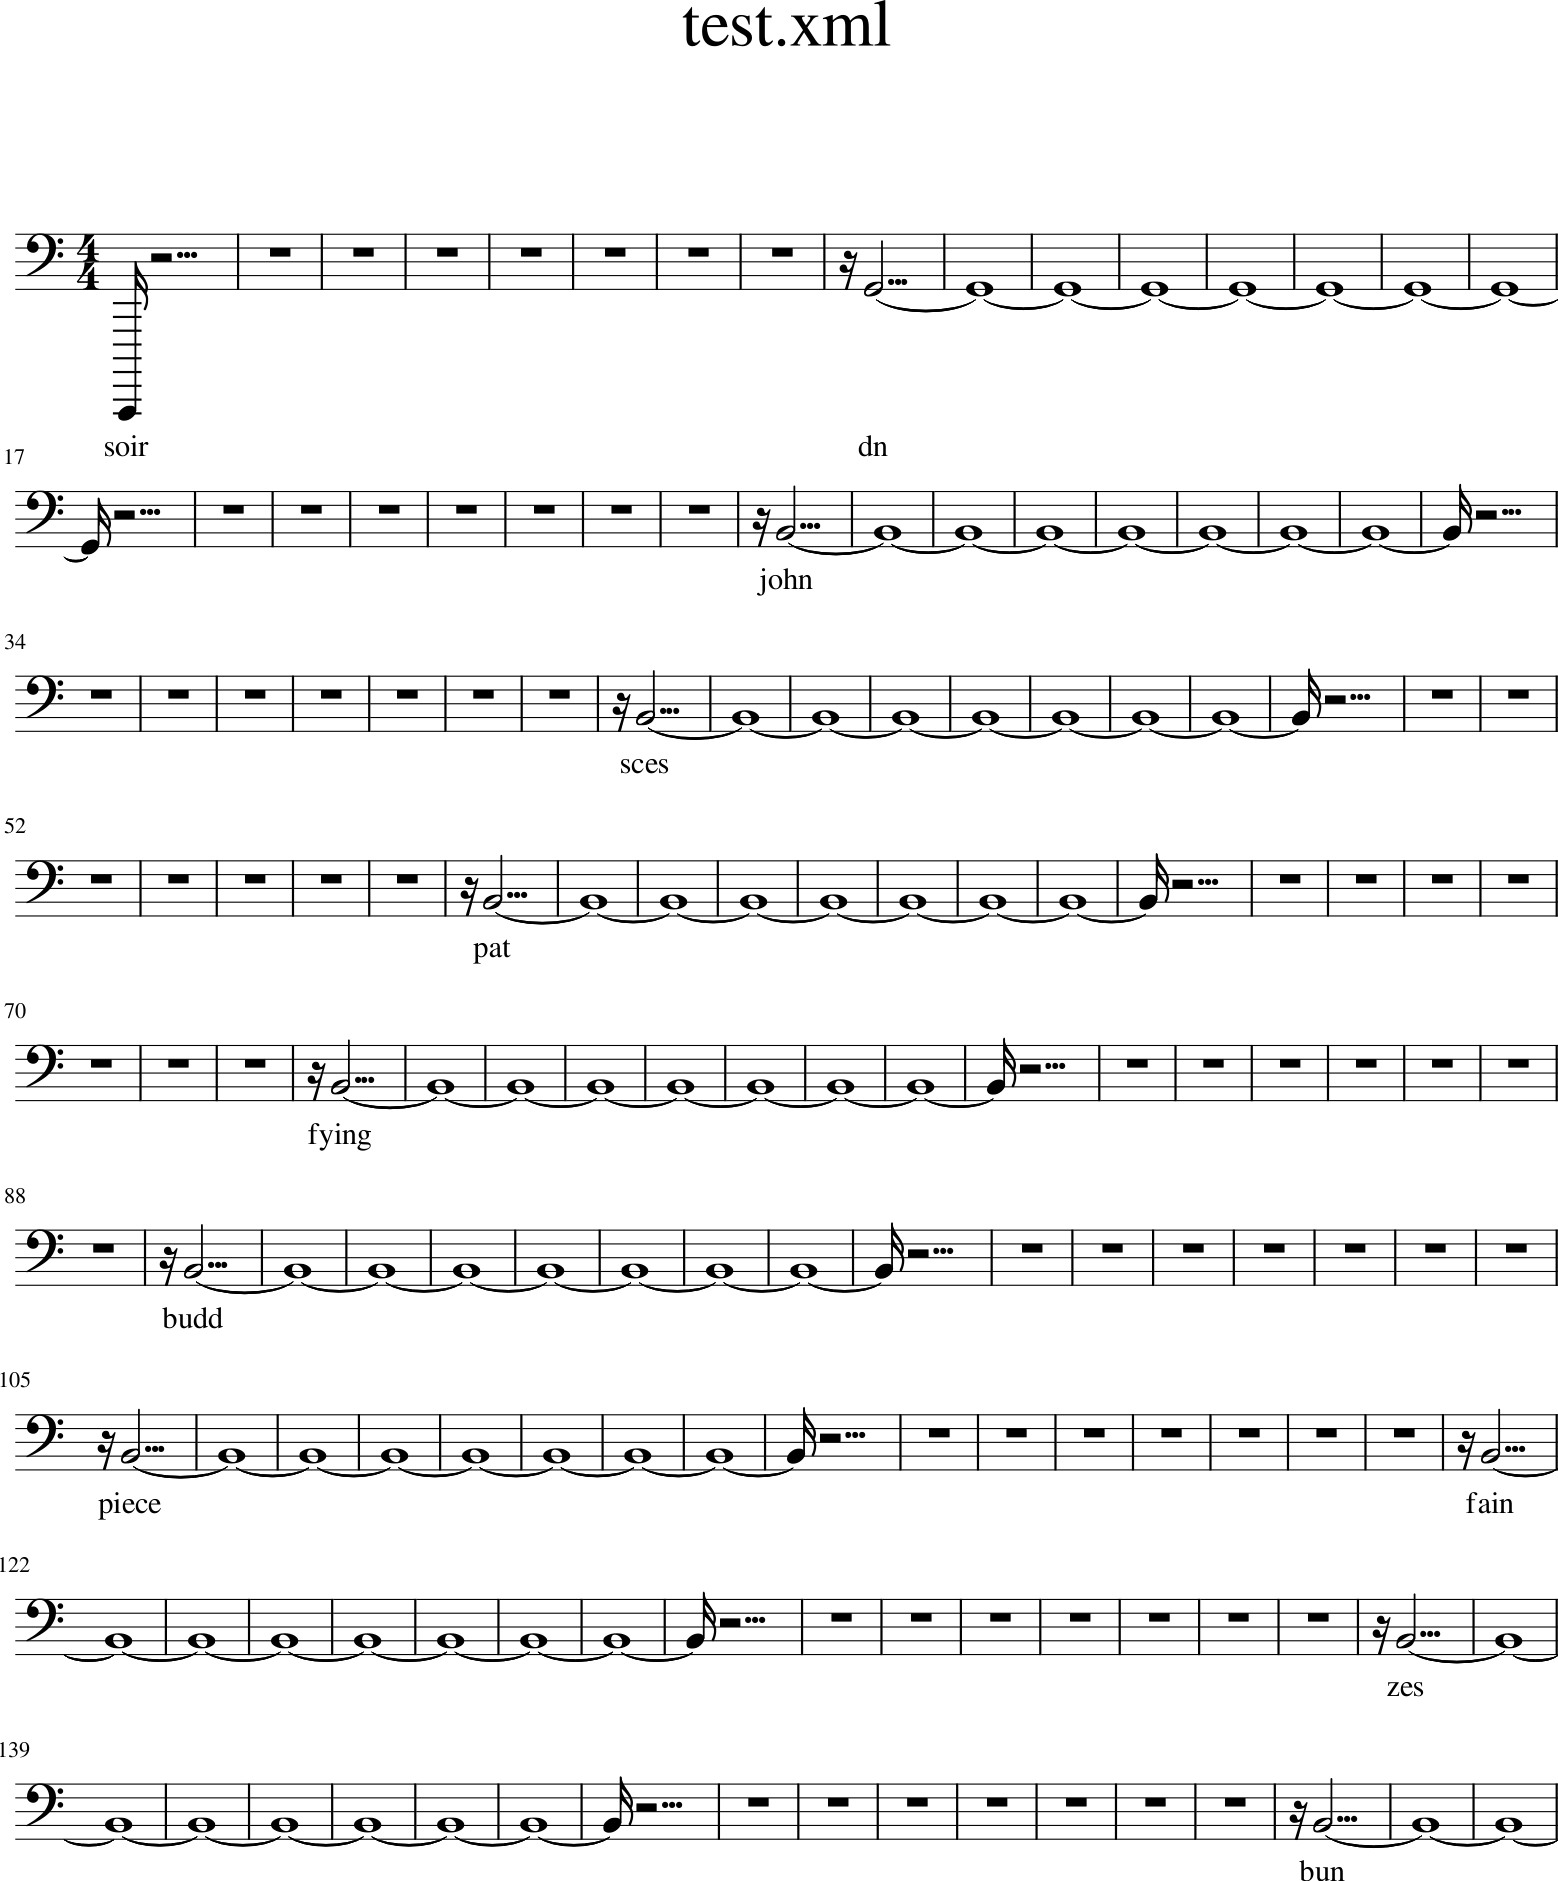

In [72]:
test = create_song("this is a test")
